# Data Science Fellowship program exam

**Machine Learning - Assignment 2: Natural disasters dataset**

By: Jules Kuehn

Due: 2020-12-03, 6pm Eastern

## Task 4: Recommendations to the clients
This notebook evaluates all the models, using the best parameters identified in the preceding experiments.

Based on these results and explainability factors, model recommendations follow.

### Setup

In [2]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
!{sys.executable} -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
# Suppress warnings for cleaner output
def warn(*args, **kwargs):
    pass

import warnings

warnings.warn = warn

import re
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             f1_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

bert_model = SentenceTransformer('all-MiniLM-L6-v2') # W = 384

### Import data
Unfortunately, the test data provided from Kaggle does not contain labels.

Therefore we cannot use it to report on the model performance.

For our final evaluation, we will simply use a different, unseen split of the train/validation compared to previous notebooks.

In [31]:
train_df = pd.read_csv('../data/raw/train.csv')

### Define pre-processing and model-building functions
For more details on these functions and parameters, please see the previous notebooks.

In [32]:
def preprocess_texts(
    texts,
    replace_numbers=True,
    replace_mentions=True,
    replace_hashtags=True,
):
    """
    Preprocess texts for NLP.
    Takes a list or Series of texts and returns a list of preprocessed texts.
    """
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    
    for i, text in enumerate(texts):
        if replace_numbers:
            # Replace any substring of digits with ' number ' using regex
            text = re.sub(r'\d+', ' number ', text)
        if replace_mentions:
            # For pre-trained embeddings, we want to use common words
            text = text.replace('@', ' at ')
        if replace_hashtags:
            text = text.replace('#', ' hashtag ')
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        # Remove leading and trailing whitespace
        text = text.strip()
        texts[i] = text
    return texts


def create_vectorizer(
    non_disaster_tweets,
    disaster_tweets,
    initial_vocab='all',
    remove_n_common_words=5,
    min_df=5,
    max_features=None,
    strip_accents='ascii',
    lowercase=True,
    ngram_range=(1, 1),
    ):
    """
    Create a CountVectorizer for use in a bag-of-words model.
    Takes a list of non-disaster tweets and a list of disaster tweets.
    Optionally removes some common or uncommon words.
    Returns a CountVectorizer with the limited vocabulary.
    """

    if initial_vocab == 'disaster':
        initial_vocab_tweets = disaster_tweets
    else:
        initial_vocab_tweets = non_disaster_tweets + disaster_tweets

    # Get vocabulary from tweets (optionally removing uncommon words)
    transformer = CountVectorizer(
        strip_accents=strip_accents,
        lowercase=lowercase,
        min_df=min_df,
        max_features=max_features,
        ngram_range=ngram_range,
    ).fit(initial_vocab_tweets)

    if remove_n_common_words > 0:
        final_vocabulary = transformer.vocabulary_.copy()
        # Get the most common words in the non-disaster tweets
        transformer = CountVectorizer(
            strip_accents=strip_accents,
            lowercase=lowercase,
            min_df=min_df,
            ngram_range=ngram_range,
        ).fit(non_disaster_tweets)
        bow = transformer.transform(list(non_disaster_tweets) + list(disaster_tweets))
        word_freqs = dict(zip(
            transformer.get_feature_names_out(),
            np.asarray(bow.sum(axis=0))[0]
        ))
        common_words = sorted(
            word_freqs.items(), key=lambda x: x[1], reverse=True
        )[:remove_n_common_words]

        # Remove most common non-disaster words from disaster tweets vocabulary
        for word in common_words:
            final_vocabulary.pop(word[0], None)

        # Create the final vectorizer with the limited vocabulary
        transformer = CountVectorizer(
            strip_accents=strip_accents,
            lowercase=lowercase,
            vocabulary=final_vocabulary.keys(),
            ngram_range=ngram_range,
        ).fit(disaster_tweets)
    
    return transformer

# Load the spacy model
# Note: better performance with larger models, but slower to load
nlp = spacy.load('en_core_web_sm') # W = 96

def embed_text_spacy(texts):
    """
    Embed a list of text using a spacy model.
    """
    return np.array([nlp(text).vector for text in texts])

def embed_text_sbert_sm(texts):
    """
    Embed a list of text using a sentence transformer model.
    """
    return bert_model.encode(texts)

def train_embeddings(
    train_df,
    embedding_function,
    clean=False,
    max_iter=1000,
):

    texts = train_df['text']
    if clean:
        texts = preprocess_texts(texts)
    
    X_train = embedding_function(texts)
    y_train = train_df['target']

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=0,
    )

    model = SGDClassifier(
        max_iter=max_iter,
    )

    model.fit(X_train, y_train)

    # Make predictions on the validation set
    preds_val = model.predict(X_val)

    # Display results on validation set
    print(classification_report(y_val, preds_val))
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues', normalize='true')
    
    return embedding_function, model, X_train, X_val, y_train, y_val


def train_bow(
    train_df,
    strip_accents='ascii',
    lowercase=True,
    initial_vocab='all',
    remove_n_common_words=5,
    min_df=5,
    max_features=None,
    ngram_range=(1, 1),
    use_idf=True,
    norm='l2',
    smooth_idf=True,
    sublinear_tf=False,
    clf=LogisticRegression(),
    tfidf=True,
):

    # Split the training data into training and validation sets
    all_tweets = train_df['text'].tolist()

    X_train = all_tweets
    y_train = train_df['target']

    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=0,
    )

    train_df = pd.DataFrame({'text': X_train, 'target': y_train})

    non_disaster_tweets = train_df[train_df['target'] == 0]['text'].tolist()
    disaster_tweets = train_df[train_df['target'] == 1]['text'].tolist()

    # Create vectorizer with limited vocabulary
    vectorizer = create_vectorizer(
        non_disaster_tweets,
        disaster_tweets,
        initial_vocab=initial_vocab,
        remove_n_common_words=remove_n_common_words,
        min_df=min_df,
        max_features=max_features,
        strip_accents=strip_accents,
        lowercase=lowercase,
        ngram_range=ngram_range,
    )
    
    # Fit TF-IDF transformer
    tfidf_transformer = TfidfTransformer(
        use_idf=use_idf,
        norm=norm,
        smooth_idf=smooth_idf,
        sublinear_tf=sublinear_tf,
    ).fit(vectorizer.transform(all_tweets))

    # Create a pipeline to vectorize and apply TF-IDF
    # Classifier is passed as an argument for comparison
    pipeline = Pipeline([
        ('vect', vectorizer),
        ('tfidf', tfidf_transformer if tfidf else None),
        ("clf", clf),
    ])

    pipeline.fit(X_train, y_train)

    # Make predictions on the validation set
    preds_val = pipeline.predict(X_val)

    # Display results on validation set
    print(classification_report(y_val, preds_val))
    ConfusionMatrixDisplay.from_estimator(pipeline, X_val, y_val, cmap='Blues', normalize='true')
    
    return pipeline, X_train, X_val, y_train, y_val

### Model training and evaluation

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       886
           1       0.80      0.70      0.74       637

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       886
           1       0.76      0.78      0.77       637

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



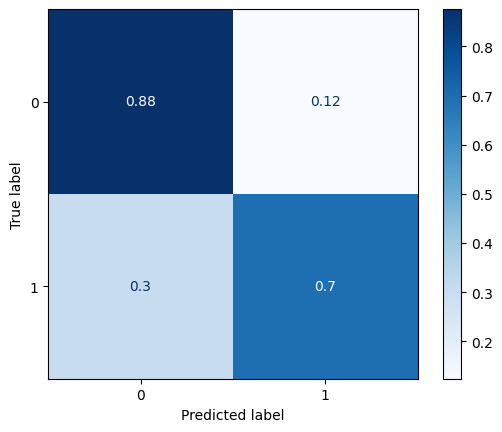

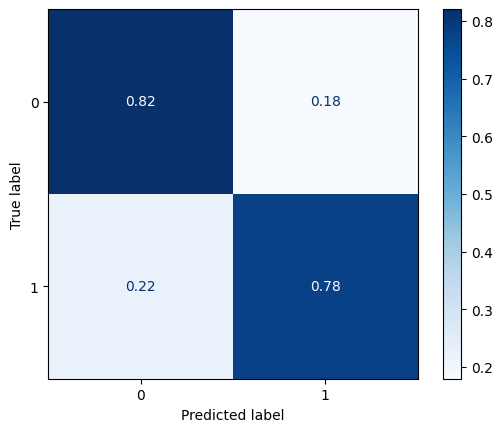

In [34]:
bow_pipeline, bow_X_train, bow_y_train, bow_X_val, bow_y_val = train_bow(
    train_df,
    clf=LogisticRegression(max_iter=2000, random_state=42),
    tfidf=False,
    ngram_range=(1, 1)
)

embedding_function, sgd_model, bert_X_train, bert_y_train, bert_X_val, bert_y_val = train_embeddings(
    train_df,
    embedding_function=embed_text_sbert_sm,
    clean=False,
    max_iter=1000,
)

### Summary of results


#### Bag of Words / TF-IDF models

My recommendation is that a simple Bag of Words model with Logistic Regression classifier is deployed for this application.

These models are simple, fast, and explainable.

The following preprocessing steps yielded the best results:
* Create a vocabulary based on all tweets, not just disaster tweets.
* Use CountVectorizer's built-in preprocessing to lowercase and strip ASCII punctuation.
* Remove the 5 most common words in non-disaster tweets.
* Remove words with less than 5 instances in the corpus.

Other preprocessing was evaluated, but decreased performance:
* Replacing numbers, @mentions or #hashtags
* Lemmatizing
* Removing stopwords
* Creating vocabulary based on disaster tweets only
* Limiting the size of the vocabulary to a fixed number (e.g. 1000)

We evaluated the effect of additional feature engineering:
* TF-IDF weighting
* Bigrams
* Trigrams

And several different ML models:
* Logistic Regression
* Random Forest
* SGD
* SVC
* Linear SVC
* Multinomial Naive Bayes

The best results came from the simplest model:

**A simple bag of words model with Logistic Regression.**


#### Word embedding model: Sentence-BERT

We evaluated 2 different sentence embedding methods:
* [Spacy document vectors](https://spacy.io/api/doc#vector) - average of word vectors in tweet (96 dimensional model)
* [Sentence-BERT](https://github.com/UKPLab/sentence-transformers) - embeds sentence (384 and 768 dimensional models)

We tried both raw and cleaned text for each model, fed into a SGD Classifier with maximum 1000 or 2000 iterations.

Not surprisingly, the 96-dimensional Spacy model performs quite poorly. The input to our ML model has been downsized from over 1000 dimensions in the BoW or TF-IDF case, to under 100.

The 384-dimensional BERT model offers a slight improvement in classification performance vs. BoW:
* The F1 macro score increases by around 1 percent.
* Predictions on actual disasters improves.

However, we lose the ability to explain what words contributed to the model's prediction. (An embedding-based approach could be made explainable if were to use individual word vectors.)

Moreover, if we want better performance on actual disasters, we can adjust the tradeoff of the simpler bag of words model to reach similar results as BERT has here.

**Given the constraints in this assignment, I would recommend that the client use the simple bag of words model.**

### Explaining the models

An advantage of the bag of words + logistic regression model is its simplicity. (In contrast, the predictions from the BERT model are not explainable.)

We can simply look up the model coefficients to determine feature importance:
* Which words contribute to a classification of "disaster" (1) or "non-disaster" (0)?

In [36]:
model_coefficients = pd.DataFrame(
   bow_pipeline['clf'].coef_.T,
   columns=['Coefficients'], index=bow_pipeline['vect'].get_feature_names_out()
)

sorted_words = model_coefficients.sort_values('Coefficients', ascending=False)
print('The following words have the highest positive coefficients (disaster):')
print(sorted_words.head(10).to_string())

print('\nThe following words have the most negative coefficients (non-disaster):')
print(sorted_words.tail(10)[::-1].to_string())

The following words have the highest positive coefficients (disaster):
            Coefficients
hiroshima       2.488386
earthquake      2.349858
floods          2.250058
derailment      2.185063
drought         2.179817
wildfire        2.171856
fires           2.038464
evacuated       1.936670
typhoon         1.908685
bombing         1.833465

The following words have the most negative coefficients (non-disaster):
        Coefficients
ebay       -1.579979
poll       -1.423761
bags       -1.294496
jeb        -1.288731
cake       -1.283634
longer     -1.259553
put        -1.220708
impact     -1.215139
mayhem     -1.196090
mode       -1.195744


#### Explaining a single prediction

In [37]:
def predict_and_explain(tweet, pipeline):
    """Predict the class of a tweet and explain the prediction."""
    bow = pipeline['vect'].transform([tweet])
    prediction = pipeline['clf'].predict(bow)[0]
    word_importance = []
    
    # Get words from bow
    words = pipeline['vect'].get_feature_names_out()

    # Get model coefficients
    coefficients = pipeline['clf'].coef_[0]

    # Get coefficients for words in the tweet
    for i, word in enumerate(words):
        if bow[0, i] > 0:
            word_importance.append((word, coefficients[i]))

    word_importance = sorted(word_importance, key=lambda x: x[1], reverse=True)

    print(f'Prediction: {"disaster" if prediction == 1 else "non-disaster"}\n')
    for word, coefficient in word_importance:
        print(f'{word}: {coefficient:.2f}')
    
    return prediction, word_importance


In [42]:
tweet = train_df['text'].sample(1).values[0]
print(tweet, '\n')

prediction, word_importance = predict_and_explain(tweet, bow_pipeline)


PAGASA 7:12am: YELLOW warning - Panay Island Guimaras Negros. Possible floods in low-lying areas &amp; landslides in mountainous areas. 

Prediction: disaster

floods: 2.25
possible: 0.80
areas: 0.57
island: 0.09
low: 0.03
amp: 0.00
